> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений



В проект добавлены методы:
в качестве аугментации - albumentations,
архитектура сетей - EfficientNetB6(с weights='noisy-student'),
transfer learning и fine-tuning настройка LR подобраны переменные (размер картинки, батч и т.д.),
добавлена Batch Normalization и изменена архитектура “головы”
дополнительные функции callback Keras,
TTA (Test Time Augmentation)




In [1]:
!nvidia-smi

Thu Apr 22 13:35:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-9maprfsg
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-9maprfsg
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=f8afb430d618a1c01ce8edef3950d1568f373d6938e50e8a295757d83d4b075f
  Stored in directory: /tmp/pip-ephem-wheel-cache-laxo3jw9/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
!pip install -q efficientnet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ImageDataAugmentor.image_data_augmentor import *
import albumentations
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [5]:
!pip freeze > requirements.txt

# Основные настройки

In [6]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [7]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

<AxesSubplot:>

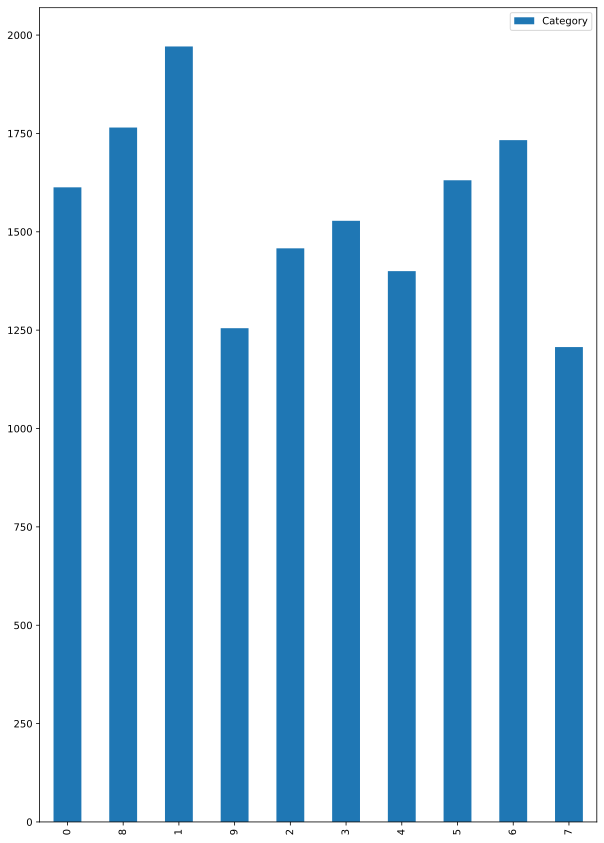

In [11]:
pd.DataFrame(train_df['Category'].value_counts(sort=False)).plot(kind='bar', figsize=(10,15))

In [12]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


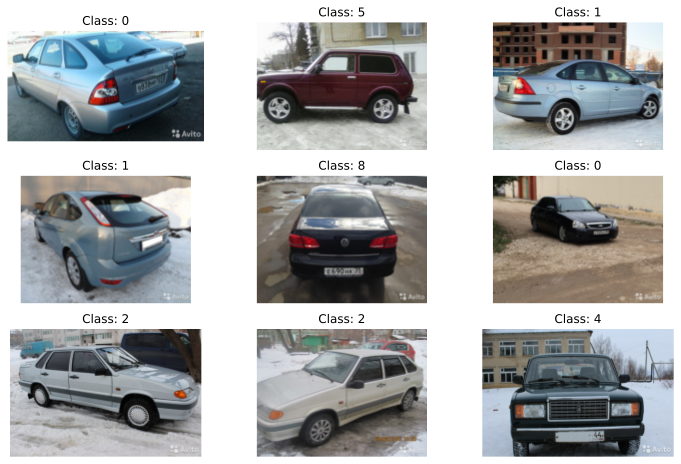

In [13]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

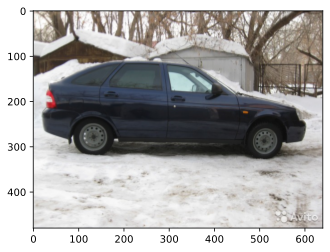

(640, 480)

In [14]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [15]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.1), # horizontally flip 50% of all images
    albumentations.VerticalFlip(p=0.2), # vertically flip 20% of all images
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),    
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=1),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

# dataloaders
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT, # set validation split
        preprocess_input=None)

test_datagen = ImageDataAugmentor(rescale=1./255)


### Генерация данных

In [16]:
# Завернем наши данные в генератор:

#datagen.fit(x_train, augment=True)
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


Пример картинок из train_generator


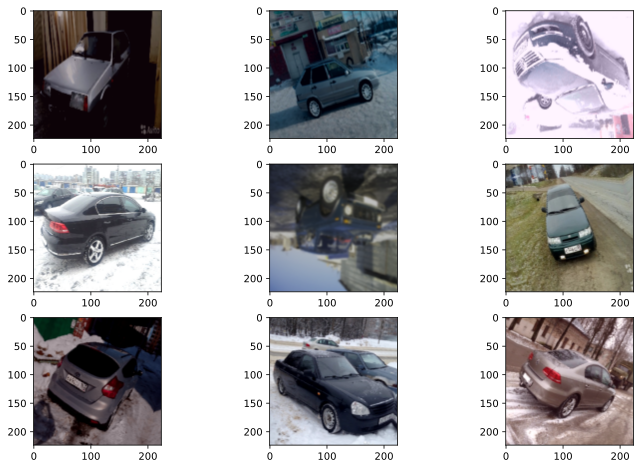

In [17]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


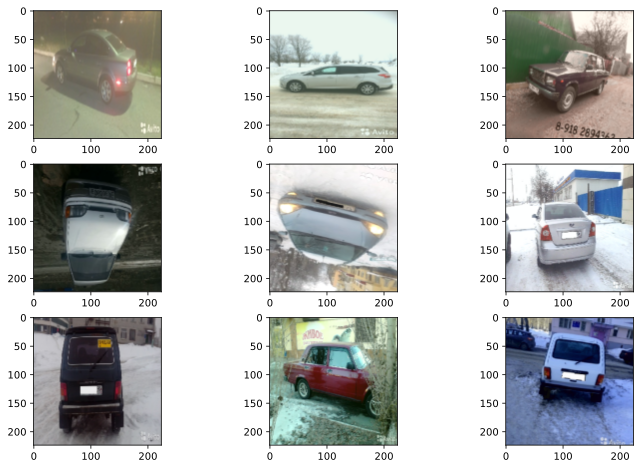

In [18]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

### Загружаем предобученную сеть EfficientNetB6 с весами от noisy-student:

In [19]:
base_model = efn.EfficientNetB6(weights='noisy-student', include_top=False, input_shape=input_shape)

165232640/165226952 [==============================] - 3s 0us/step


In [20]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [21]:
print(len(base_model.layers))

659


In [22]:
#обучаем только верхние слои "голову"
base_model.trainable = False

In [23]:
# Устанавливаем новую "голову" (head)
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization()) #добавляем BatchNormalization
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))


In [24]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [26]:
# количество слоев 
print(len(model.layers))

6


In [27]:
# смотрим какие слои обучаются
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f184ba34fd0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f184b97a590> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f186c3a4ed0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f186c3adf10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f186c3afd90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f186c3ad3d0> True


## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [28]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

Обучаем:

In [29]:
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        callbacks = callbacks_list)
# Рекомендация: попробуйте применить transfer learning с fine-tuning callbacks = callbacks_list

Epoch 1/10
207/207 [==============================] - 166s 718ms/step - loss: 2.3672 - accuracy: 0.2395 - val_loss: 1.6578 - val_accuracy: 0.3989

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 143s 692ms/step - loss: 1.9056 - accuracy: 0.3294 - val_loss: 1.5516 - val_accuracy: 0.4354

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 143s 690ms/step - loss: 1.8182 - accuracy: 0.3460 - val_loss: 1.5148 - val_accuracy: 0.4573

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
207/207 [==============================] - 143s 689ms/step - loss: 1.7753 - accuracy: 0.3603 - val_loss: 1.4662 - val_accuracy: 0.4762

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 143s 691ms/step - loss: 1.7157 - accuracy: 0.3862 - val_loss: 1.4748 - val_accuracy: 0.4667

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
207/207 [====================

In [30]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [31]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 21s 561ms/step - loss: 1.3844 - accuracy: 0.5075
Accuracy: 50.75%


В Итоге точность нашей модели составила 49%. 
    
Посмотрим графики обучения:

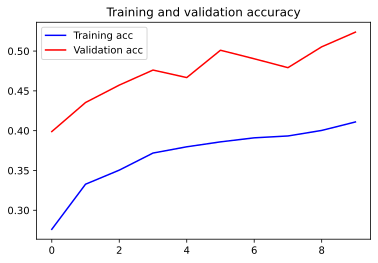

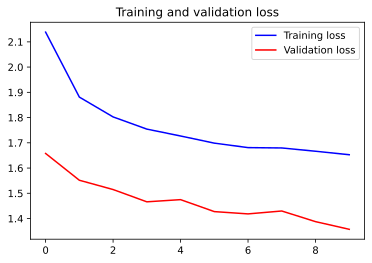

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

FineTuning

**шаг 2**

In [33]:
print("Количество слоев в базе: ", len(base_model.layers))


# возьмем половину слоев у базовой модели
base_model.trainable = True
#настройка, начиная с этого слоя
fine_tune_at = len(base_model.layers)//2
# Заморозим все слои перед тонкой надстройкой
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


#смотрим количество слоев
len(base_model.trainable_variables)




Количество слоев в базе:  659


291

In [34]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f184ba34fd0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f184b97a590> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f186c3a4ed0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f186c3adf10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f186c3afd90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f186c3ad3d0> True


In [35]:
# уменьшим LR
LR=1e-4
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
____________________________________

In [36]:
#обучим
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 192s 834ms/step - loss: 2.0380 - accuracy: 0.2990 - val_loss: 1.0993 - val_accuracy: 0.6041

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 168s 811ms/step - loss: 1.3015 - accuracy: 0.5247 - val_loss: 0.7703 - val_accuracy: 0.7029

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 167s 807ms/step - loss: 0.9695 - accuracy: 0.6462 - val_loss: 0.5922 - val_accuracy: 0.7797

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
207/207 [==============================] - 170s 818ms/step - loss: 0.7476 - accuracy: 0.7241 - val_loss: 0.4555 - val_accuracy: 0.8257

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 168s 812ms/step - loss: 0.6229 - accuracy: 0.7765 - val_loss: 0.4090 - val_accuracy: 0.8510

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
207/207 [====================

In [37]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [38]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 21s 570ms/step - loss: 0.2644 - accuracy: 0.9038
Accuracy: 90.38%


Точность нашей модели уже 90%.

Теперь используем все слои

**Шаг 3**

In [39]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

len(base_model.trainable_variables)

493

In [40]:
EPOCHS               = 7  # делаю меньше эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [41]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [42]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [43]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
        )

Epoch 1/7
1654/1654 [==============================] - 357s 203ms/step - loss: 0.7808 - accuracy: 0.7502 - val_loss: 0.3611 - val_accuracy: 0.8738

Epoch 00001: saving model to best_model.hdf5
Epoch 2/7
1654/1654 [==============================] - 334s 202ms/step - loss: 0.6532 - accuracy: 0.7809 - val_loss: 0.3074 - val_accuracy: 0.8897

Epoch 00002: saving model to best_model.hdf5
Epoch 3/7
1654/1654 [==============================] - 335s 202ms/step - loss: 0.5775 - accuracy: 0.8048 - val_loss: 0.3040 - val_accuracy: 0.8939

Epoch 00003: saving model to best_model.hdf5
Epoch 4/7
1654/1654 [==============================] - 336s 203ms/step - loss: 0.5288 - accuracy: 0.8173 - val_loss: 0.2831 - val_accuracy: 0.9021

Epoch 00004: saving model to best_model.hdf5
Epoch 5/7
1654/1654 [==============================] - 337s 204ms/step - loss: 0.4761 - accuracy: 0.8380 - val_loss: 0.2325 - val_accuracy: 0.9137

Epoch 00005: saving model to best_model.hdf5
Epoch 6/7
1654/1654 [==============

In [44]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [45]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 22s 75ms/step - loss: 0.2490 - accuracy: 0.9051
Accuracy: 90.51%


91,5% Нда

Увеличим размер изображения

In [46]:
EPOCHS               = 5
BATCH_SIZE           = 4
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [47]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [48]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [49]:
base_model = efn.EfficientNetB6(weights='noisy-student', include_top=False, input_shape=input_shape)

In [50]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [51]:
# Подгружаем ранее обученные веса
model.load_weights('best_model.hdf5')
callbacks_list = [checkpoint, earlystop]

In [52]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
3308/3308 [==============================] - 1383s 411ms/step - loss: 0.7427 - accuracy: 0.7597 - val_loss: 0.1268 - val_accuracy: 0.9648

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
3308/3308 [==============================] - 1360s 411ms/step - loss: 0.4407 - accuracy: 0.8600 - val_loss: 0.1181 - val_accuracy: 0.9631

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
3308/3308 [==============================] - 1362s 412ms/step - loss: 0.3794 - accuracy: 0.8815 - val_loss: 0.1129 - val_accuracy: 0.9661

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
3308/3308 [==============================] - 1362s 412ms/step - loss: 0.3276 - accuracy: 0.8959 - val_loss: 0.1103 - val_accuracy: 0.9691

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
3308/3308 [==============================] - 1356s 410ms/step - loss: 0.2773 - accuracy: 0.9115 - val_loss: 0.1062 - val_accuracy: 0.9652

Epoch 00005: saving model to best_model.hdf5


In [53]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [54]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 67s 114ms/step - loss: 0.1092 - accuracy: 0.9678
Accuracy: 96.78%


# Предсказание на тестовых данных

In [55]:
test_sub_generator.samples

6675

In [56]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 190s 112ms/step


In [57]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [58]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


TTA

In [59]:
model.load_weights('best_model.hdf5')

In [60]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [61]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [62]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 206s 123ms/step


In [63]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)

print('Save submit')

Save submit


In [64]:
tmp_y = pd.concat([submission['Id'], test_files['Category']], axis=1, sort=False)
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Id'],)*100))

NameError: name 'test_files' is not defined

In [65]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот эти автомобили?

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!